In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob  
import random
import warnings
import math 
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading data and calculating inter-arrival times

In [16]:
file_path_100 = "/home/asabzi/switch_ipg/revised_data/ts_100Mbps"
file_path_1000 = "/home/asabzi/switch_ipg/revised_data/ts_1000Mbps"
df_100 = pd.read_csv(file_path_100,names=['dummy_1', 'timestamp', 'dummy_2', 'seq', 'dummy_3', 'packet_count'], delim_whitespace=True)
df_1000 = pd.read_csv(file_path_1000,names=['dummy_1', 'timestamp', 'dummy_2', 'seq', 'dummy_3', 'packet_count'], delim_whitespace=True)
df_100.drop(columns=['dummy_1', 'dummy_2', 'dummy_3'], inplace=True)
df_1000.drop(columns=['dummy_1', 'dummy_2', 'dummy_3'], inplace=True)
df_100.head()

,timestamp,seq,packet_count
0,2118067299062,12706,8
1,2118067575214,12707,9
2,2118067575321,12708,10
3,2118067575427,12709,11
4,2118067575535,12710,12


In [26]:
df_rtx_1_100 = df_100.iloc[:-1,:].reset_index()
df_rtx_2_100 = df_100.iloc[1:,:].reset_index()
df_rtx_1_1000 = df_1000.iloc[:-1,:].reset_index()
df_rtx_2_1000 = df_1000.iloc[1:,:].reset_index()

df_100_diff = df_rtx_2_100 - df_rtx_1_100
df_1000_diff = df_rtx_2_1000 - df_rtx_1_1000

df_100

,timestamp,seq,packet_count
0,2118067299062,12706,8
1,2118067575214,12707,9
2,2118067575321,12708,10
3,2118067575427,12709,11
4,2118067575535,12710,12
...,...,...,...
4636342,2303129360737,61528,4636350
4636343,2303129360846,61529,4636351
4636344,2303129360954,61530,4636352
4636345,2303129361062,61531,4636353


## Checking the refinement of data

In [5]:
uniques = df_100_diff['seq'].unique()
print("Unique values in intervals for 100 Mbps: " )
print(uniques)

uniques = df_1000_diff['seq'].unique()
print("Unique values in intervals for 1000 Mbps: ")
print(uniques)

Unique values in intervals for 100 Mbps: 
[     1 -65535]
Unique values in intervals for 1000 Mbps: 
[     1 -65535]


## Stats of inter-arrival times for all traffic

In [6]:
#hist_100 = (df_100_diff['timestamp']).hist(bins=70)
#hist_1000 = (df_1000_diff['timestamp']).hist(bins=70)
print("The average for intervals is: [100Mbps: %.3f, 1Gbps: %.3f]ns" % (df_100_diff['timestamp'].mean(), df_1000_diff['timestamp'].mean()))
print("The std for intervals is: [100Mbps: %.3f, 1Gbps: %.3f]ns" % (df_100_diff['timestamp'].std(), df_1000_diff['timestamp'].std()))

print("Max interval is [100Mbps: %.3f, 1Gpbs: %.3f]ns " % (df_100_diff['timestamp'].max(), df_1000_diff['timestamp'].max()))
print("Min interval is [100Mbps: %.3f, 1Gpbs: %.3f]ns " % (df_100_diff['timestamp'].min(), df_1000_diff['timestamp'].min()))

The average for intervals is: [100Mbps: 39915.499, 1Gbps: 3999.328]ns
The std for intervals is: [100Mbps: 105427.333, 1Gbps: 10288.083]ns
Max interval is [100Mbps: 321244.000, 1Gpbs: 39854.000]ns 
Min interval is [100Mbps: 34.000, 1Gpbs: 24.000]ns 


## Stats of inter-arriaval times without outliers

In [7]:
def remove_outlier(dataframe, col_name, coverage_percentage=80):
    lower_bound = int(((100-coverage_percentage)/100)/2 * len(dataframe))
    higher_bound = int(len(dataframe) - lower_bound)
    df_sorted = dataframe.sort_values(by=[col_name])
    df_subdataframe = df_sorted.iloc[lower_bound:higher_bound, :]
    #print("Cover Percentage: %.3f" % (len(df_subdataframe)/len(dataframe)) + "%")
    return df_subdataframe

In [8]:
df_subIntervals_100Mbps = remove_outlier(df_100_diff, 'timestamp', 90)
df_subIntervals_1000Mbps = remove_outlier(df_1000_diff, 'timestamp', 90)

#hist = (df_subIntervals_100Mbps['timestamp']).hist(bins=70)
print("The average for intervals is: [100Mbps: %.3f, 1Gbps: %.3f]ns" % (df_subIntervals_100Mbps['timestamp'].mean(), df_subIntervals_1000Mbps['timestamp'].mean()))
print("The std for intervals is: [100Mbps: %.3f, 1Gbps: %.3f]ns" % (df_subIntervals_100Mbps['timestamp'].std(), df_subIntervals_1000Mbps['timestamp'].std()))

print("Max interval is [100Mbps: %.3f, 1Gpbs: %.3f]ns " % (df_subIntervals_100Mbps['timestamp'].max(), df_subIntervals_1000Mbps['timestamp'].max()))
print("Min interval is [100Mbps: %.3f, 1Gpbs: %.3f]ns " % (df_subIntervals_100Mbps['timestamp'].min(), df_subIntervals_1000Mbps['timestamp'].min()))

The average for intervals is: [100Mbps: 26606.225, 1Gbps: 2696.780]ns
The std for intervals is: [100Mbps: 88025.509, 1Gbps: 8575.333]ns
Max interval is [100Mbps: 319229.000, 1Gpbs: 31261.000]ns 
Min interval is [100Mbps: 105.000, 1Gpbs: 105.000]ns 


In [9]:
intervals_100_mean = []
intervals_1000_mean = []

intervals_100_std = []
intervals_1000_std = []

intervals_100_rates = []
intervals_1000_rates = []
coverages = range(10,100, 5)
for coverage in coverages:
    pkt_size = 512*8
    df_subIntervals_100Mbps = remove_outlier(df_100_diff, 'timestamp', coverage)
    df_subIntervals_1000Mbps = remove_outlier(df_1000_diff, 'timestamp', coverage)

    mean_100 = df_subIntervals_100Mbps['timestamp'].mean()
    intervals_100_mean.append(mean_100)
    std_100 = df_subIntervals_100Mbps['timestamp'].std()
    intervals_100_std.append(std_100)
    intervals_100_rates.append(pkt_size/mean_100) 

    mean_1000 = df_subIntervals_1000Mbps['timestamp'].mean()
    intervals_1000_mean.append(mean_1000)
    std_1000 = df_subIntervals_1000Mbps['timestamp'].std()
    intervals_1000_std.append(std_1000)
    intervals_1000_rates.append(pkt_size/mean_1000) 

[37.925925925925924,
 37.925925925925924,
 37.925925925925924,
 37.950288942608445,
 37.97554392270845,
 37.99133761265761,
 37.98314879745931,
 37.963154091794586,
 37.89672037723088,
 37.62588193862662,
 37.23397517762562,
 36.7192726424859,
 36.07779613112797,
 34.50568320826894,
 0.4106153638177183,
 0.21810967050956315,
 0.1539489346084356,
 0.12186926314587984]

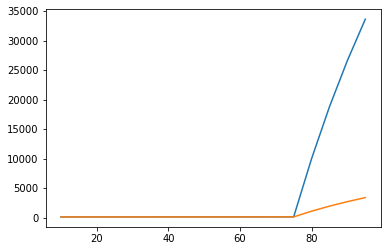

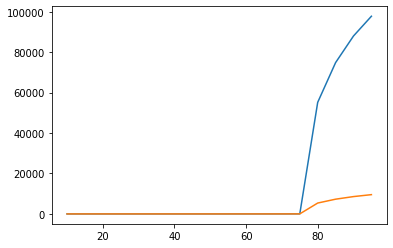

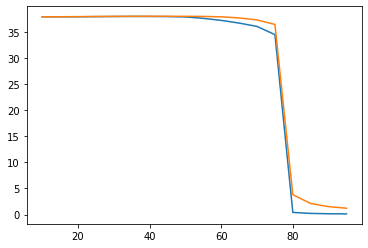

In [10]:
fig = plt.figure()
plt.plot(coverages, intervals_100_mean)
plt.plot(coverages,intervals_1000_mean)


fig = plt.figure()
plt.plot(coverages, intervals_100_std)
plt.plot(coverages,intervals_1000_std)

fig = plt.figure()
plt.plot(coverages, intervals_100_rates)
plt.plot(coverages, intervals_1000_rates)
intervals_100_rates

## Plotting traffic pattern


18506206
The average for windows rate are: 102.616606 Mbps
The std for windows rate are: 562.405174 Mbps


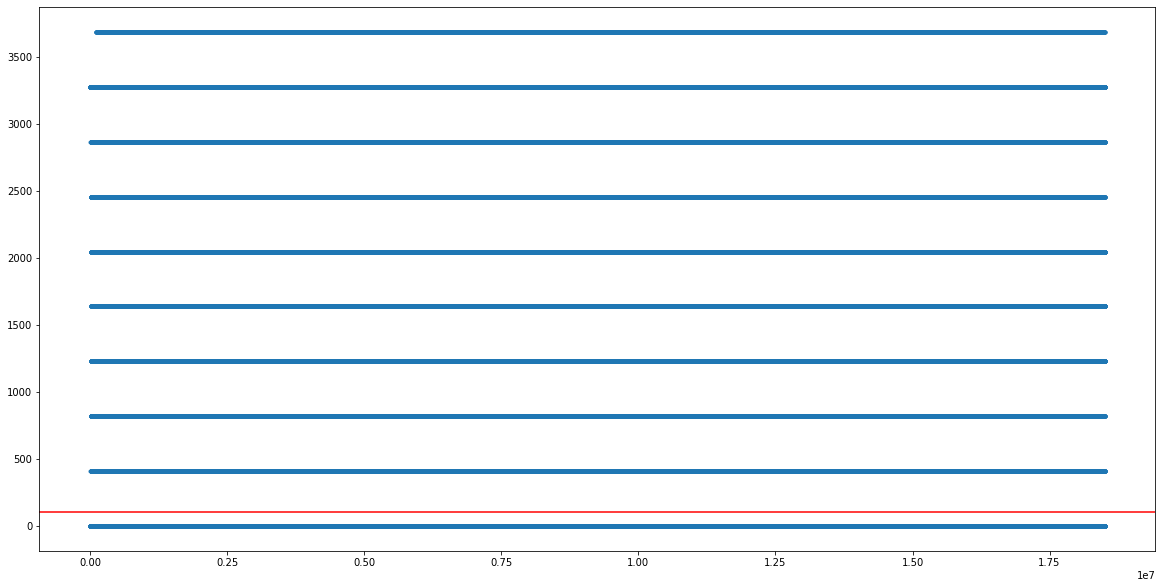

In [76]:
def binarySearch(df, value):
    lower_ind = 0
    upper_ind = len(df)-1
    while(not (df[upper_ind] >= value and df[upper_ind-1] <= value)):
        middle_ind = math.floor((upper_ind + lower_ind)/2)
        if(df[middle_ind] < value):
            lower_ind = middle_ind + 1
        else:
            upper_ind = middle_ind
    return upper_ind

def RangeSampleCounter(df, lower_bound_value, upper_bound_value):
    upper_bound_ind = binarySearch(df, upper_bound_value)
    lower_bound_ind = binarySearch(df, lower_bound_value)
    return upper_bound_ind - lower_bound_ind

def binaryWindow(df, window_size, pkt_size):
    samples_in_window = []
    window_start_value = df[0]
    window_num = math.floor((df[-1] - df[0])/window_size)
    print(window_num)
    for i in range(window_num):
        window_end_value = window_start_value + window_size
        #print("lower bound" + str(window_start_value))
        #print("upper boudn" +    str(window_end_value))
        packet_in_window_counter = RangeSampleCounter(df, window_start_value, window_end_value)
        window_start_value = window_end_value
        rate_Gbps = pkt_size * packet_in_window_counter / window_size
        rate_Mbps = rate_Gbps * 1000
        samples_in_window.append(rate_Mbps)
        '''if (sample_in_window_counter != 0):
            print("sample count: " + str(sample_in_window_counter))'''
        if i %1000 == 0:
            p = (window_start_value - df[0])/(df[-1] - df[0])
            print("Progress rate: %.3f" % (p), end='\r')

    return samples_in_window


packet_size = 512 * 8
window_size_in_us = 10



window_size = window_size_in_us * 1000 
timestamp_array = df_100['timestamp'].tolist()
overall_rate = packet_size * len(timestamp_array)/(timestamp_array[-1] - timestamp_array[0]) * 1000
rate_in_window = binaryWindow(timestamp_array, window_size, packet_size)   
fig = plt.figure(figsize=(20,10))
plt.plot(rate_in_window,'.')
plt.axhline(y=overall_rate, color='r', linestyle='-')
print("The average for windows rate are: %f Mbps" % (np.mean(rate_in_window)))
print("The std for windows rate are: %f Mbps" % (np.std(rate_in_window)))

### Plotting the whole data

In [ ]:
df_1000_diff['rate'] = 512 * 8 /df_1000_diff['timestamp']
df_1000['rate'] =  df_1000['packet_count'] * 512 * 8 / (df_1000['timestamp'] - df_1000['timestamp'].min())
avg = df_100_diff['timestamp'].mean()
512*8/(avg)
#df_100['packet_count'].max() * 512 * 8 / (df_100['timestamp'].max() - df_100['timestamp'].min()) 

0.10261678163526157

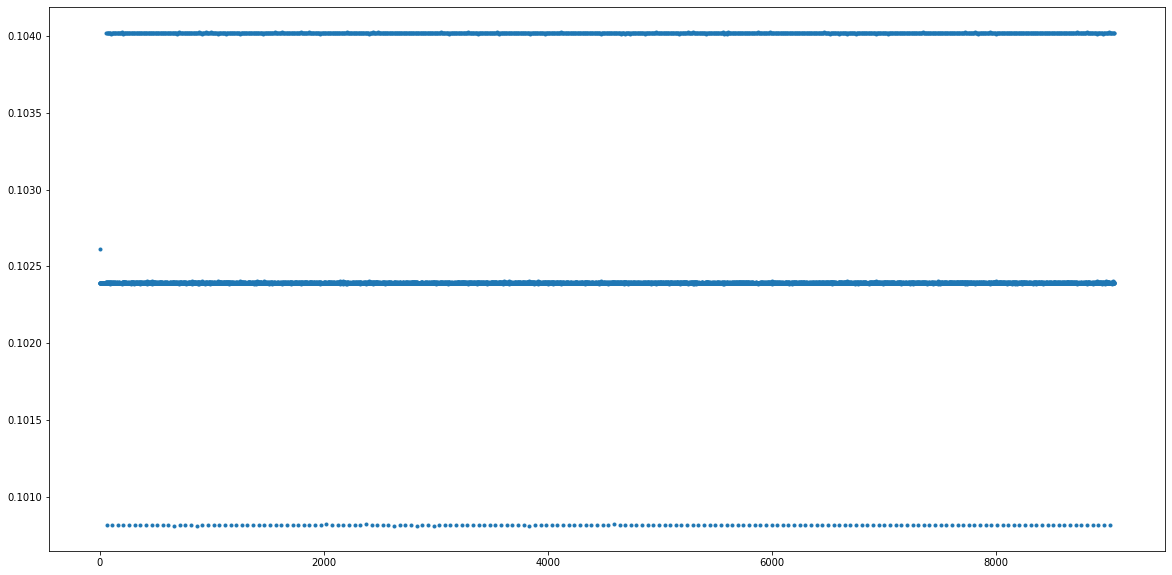

In [ ]:
def local_rate(df, pkt_size=512*8):
    df_1 = df.iloc[:-1,:].reset_index()
    df_2 = df.iloc[1:,:].reset_index()
    df_diff = df_2 - df_1
    df_diff['rate_in_window'] = pkt_size * df_diff['packet_count'] / df_diff['timestamp']
    return df_diff


    
def traffic_pattern(dataframe, window_size):
    df_len = len(dataframe)
    df_downsampled = dataframe.iloc[::window_size]
    df_ds_rates = local_rate(df_downsampled)
    df_ds_len = len(df_ds_rates)
    res = random.sample(range(1, df_ds_len), 30)
    #display(df_ds_rates.loc[res])
    return df_ds_rates

    #for indx, row in dataframe.iterrows():
    #    print("Progress rate: %.3f" % (indx/df_len), end='\r')
df = traffic_pattern(df_100, 512)


fig = plt.figure(figsize=(20,10))
plt.plot(df['rate_in_window'],'.')
